# Data Assimilation on real fires using EnKF

In [1]:
from putils import get_observation, plot_geometry, plot_matrix, validate_geom
from dautils import sample_winddirection, sample_windspeed,  adjusted_state_EnKF_farsite, geom_to_state, align_states, sample_geometry, interpolate_geom, validate_geom, geom_to_state
from futils import forward_pass_farsite, generate_landscape

from shapely import Polygon

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import pickle
import datetime
import os
import contextily as ctx

import geopandas as gpd
import pandas as pd

ModuleNotFoundError: No module named 'shapely'

In [2]:
# Error calculation functions
def calculate_rms_state(state1, state2):
    return np.sqrt(((state1 - state2)**2).mean())
def calculate_area_diff_state(state1, state2):
    geom1 = Polygon(zip(state1[::2], state1[1::2]))
    geom2 = Polygon(zip(state2[::2], state2[1::2]))
    
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

def calculate_rms_geom(geom1, geom2):
    state1 = geom_to_state(geom1)
    state2 = geom_to_state(geom2)
    
    aligned_state1, aligned_state2 = align_states([state1, state2], vertex_count=1000)
    return calculate_rms_state(aligned_state1, aligned_state2)

## Simulated fire - a

- Consistent wind through northeast (winddirection = 215)
- Starting from a 100x100 ft square at corner x = -2160773.1329818494, y = 1593618.354704436
- Burn for 12 hours with outputs every 30 minutes

### Ignition

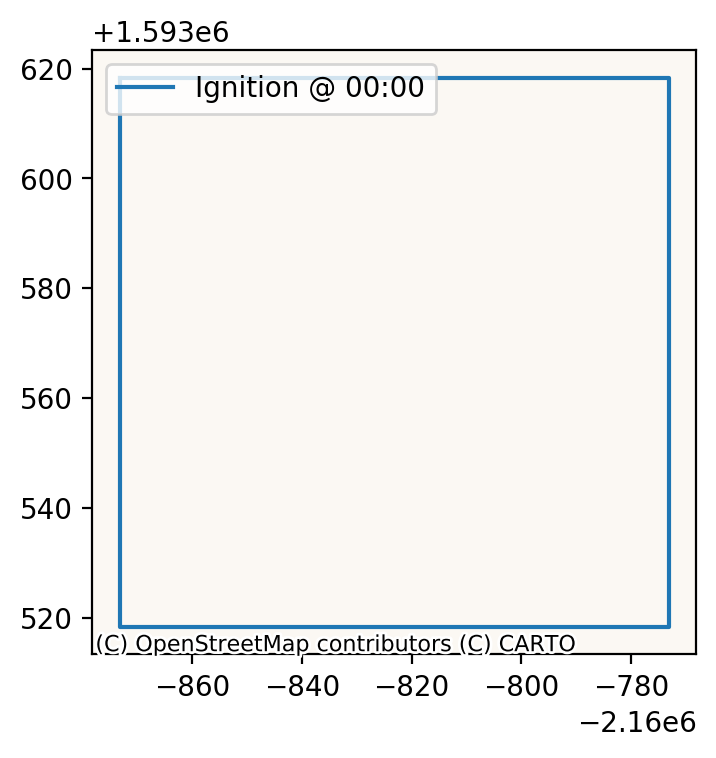

In [3]:
description = 'SimFire-a'

# Define ignition
x = -2160773.1329818494
y = 1593618.354704436
width = 100  # width of the square
ignition = Polygon([(x-width, y), (x, y), (x,y-width), (x-width, y-width)])
ignition_timepoint = pd.to_datetime(datetime.datetime(year=2024, month=12, day=1))

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax, label=f'Ignition @ {ignition_timepoint.strftime("%H:%M")}')
ax.legend(loc='upper left')

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:5070')

### Generating ground truth for the simulated fire - a

In [4]:
# Define timepoints
dt = datetime.timedelta(minutes=30)
final_timepoint = pd.to_datetime(ignition_timepoint + datetime.timedelta(hours=12))

# Each entry in timestamps corespond to a FARSITE calculation starting from an ignition at the same array index
timestamps = np.arange(ignition_timepoint, final_timepoint, dt, dtype=pd.Timestamp)

wsmean = 10
wssigma = 5
wdmean = 215
wdsigma = 45
wslst_ground_truth = []
wdlst_ground_truth = []
rng = np.random.Generator(np.random.PCG64(1234))
for t in range(len(timestamps)):
    wslst_ground_truth.append(sample_windspeed(wsmean, wssigma, rng))
    wdlst_ground_truth.append(sample_winddirection(wdmean, wdsigma, rng))

lcppath = generate_landscape(geom_5070=ignition, description=description)

# Calculate farsite at each timestamp from ignition
simulated_fire_ground_truth = [ignition]  # Ignition is the first entry.
for i, timestamp in tqdm(enumerate(timestamps), total=len(timestamps), desc='Generating observations...'):
    outpoly = forward_pass_farsite(poly=simulated_fire_ground_truth[-1], 
                                   params={'windspeed': wslst_ground_truth[i],
                                           'winddirection': wdlst_ground_truth[i],
                                           'dt': dt},
                                   lcppath = lcppath, description=description)
    
    simulated_fire_ground_truth.append(outpoly)

Generating observations...: 100%|██████████| 24/24 [00:19<00:00,  1.23it/s]


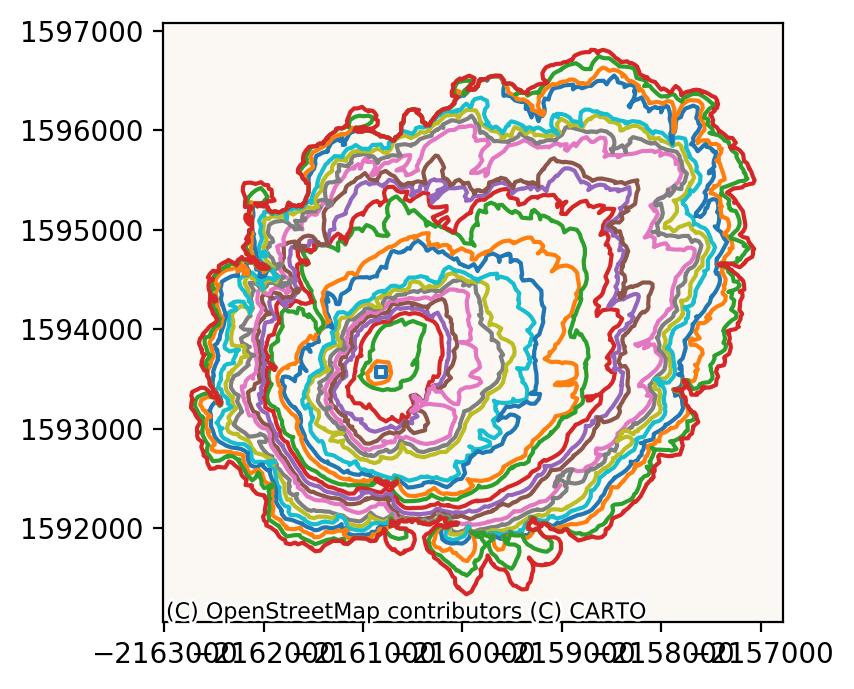

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

for i in range(len(timestamps)):
    plot_geometry(geom=simulated_fire_ground_truth[i], ax=ax)

ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:5070')

### Choose observation times and generate observations from sampling

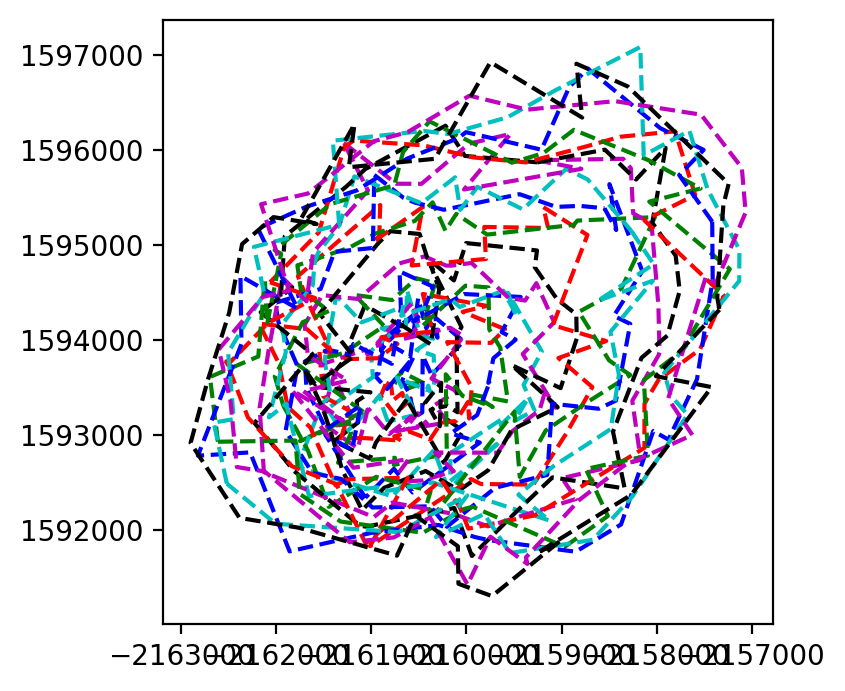

In [6]:
# obix = [1, 5, 9, 13, 17, 21]
obix = range(len(timestamps))

observation_timestamps = timestamps[obix]
observation_geoms = []
for i in obix:
    int_geom = interpolate_geom(simulated_fire_ground_truth[i], vertex_count=30)
    geom = sample_geometry(int_geom, rng, sigma=200)
    observation_geoms.append(validate_geom(geom))
    

colors=  ['r', 'g', 'b', 'c', 'm', 'k']
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
observation_errors = []
for ix, (simgeom, geom) in enumerate(zip(np.array(simulated_fire_ground_truth)[obix], observation_geoms)):
    plot_geometry(geom, ax=ax, linestyle='--', color=colors[ix%len(colors)])
#     plot_geometry(simgeom, ax=ax, color=colors[ix%len(colors)])
    observation_errors.append(calculate_rms_geom(geom, simgeom))

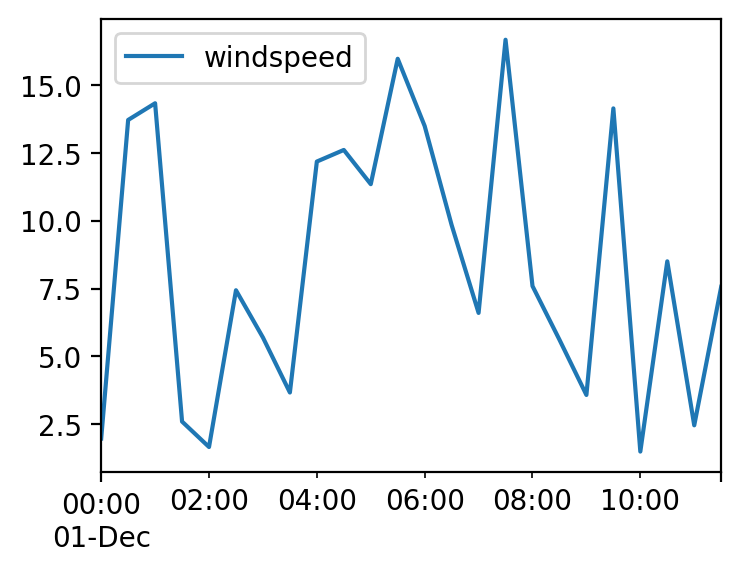

In [7]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)

pd.DataFrame({'windspeed': wslst_ground_truth}, index=timestamps).plot(ax=ax)

In [8]:
# fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
# # ax.plot(observation_timestamps, observation_errors)
# pd.DataFrame(index=observation_timestamps, data={'rms_errors': observation_errors}).plot(ax=ax, style='.')

## Simulate without any data assimilation

In [9]:
# Choose an initial wind speed
wslst_no_da = [10]*len(timestamps)
wdlst_no_da = [215]*len(timestamps)

lcppath = generate_landscape(geom_5070=ignition, description=description)

# Calculate farsite at each timestamp from ignition
simulated_fire_no_da = [ignition]  # Ignition is the first entry.
for i, timestamp in tqdm(enumerate(timestamps), total=len(timestamps), desc='Generating observations...'):
    outpoly = forward_pass_farsite(poly=simulated_fire_no_da[-1], 
                                   params={'windspeed': wslst_no_da[i],
                                           'winddirection': wdlst_no_da[i],
                                           'dt': dt},
                                   lcppath = lcppath, description=description)
    
    simulated_fire_no_da.append(outpoly)

Generating observations...: 100%|██████████| 24/24 [00:19<00:00,  1.25it/s]


### Calculate Error

24it [00:01, 17.92it/s]


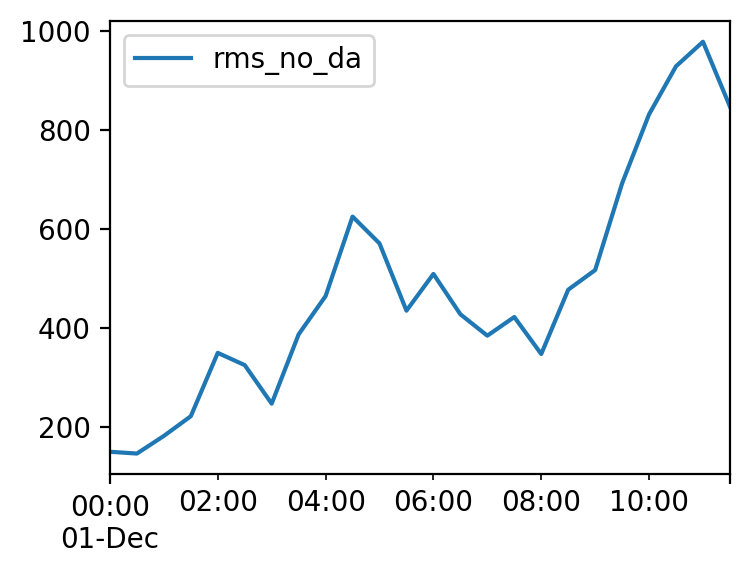

In [10]:
rms_errors_no_da = []
for sim, obs in tqdm(zip(observation_geoms, simulated_fire_no_da)):
    rms_errors_no_da.append(calculate_rms_geom(sim, obs))
    
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)
pd.DataFrame(index=observation_timestamps, data={'rms_no_da': rms_errors_no_da}).plot(ax=ax)

## Add data assimilation

### Initialize the parameters

In [11]:
n_vertex = 30
n_states = 2*n_vertex
n_samples = 5*n_states
adjusted_geom_lst = []
xkhat_ensemble_lst = []
xkphat_ensemble_lst = []
ykhat_ensemble_lst = []
zkphat_ensemble_lst = []
X_lst = []

sampled_wslst = []
sampled_wdlst = []

wssigma = 5
wdsigma = 90
vsize=100  # Observation uncertainty
wsize=100   # Model uncertainty

# FARSITE distance and perimeter resolutions
dist_res = 150
perim_res = 150

for tix in tqdm(range(len(timestamps))):
    sampled_wslst.append([])
    sampled_wdlst.append([])
    for s in range(n_samples):
        sampled_wslst[-1].append(sample_windspeed(10,wssigma,rng))
        sampled_wdlst[-1].append(sample_winddirection(215, wdsigma, rng))

100%|██████████| 24/24 [00:00<00:00, 570.03it/s]


In [12]:

###########################################
#### CALCULATE ADJUSTED MODEL OUTPUT ######
###########################################
# Input of data assimilation
n_output = n_states
tix = 0
initial_state = geom_to_state(ignition)
observation_state = geom_to_state(observation_geoms[tix])

X = 1e3*np.eye(n_states)  # Initial covariance matrix
initial_state, observation_state = align_states([initial_state, observation_state], vertex_count=n_vertex)
adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
    initial_state, observation_state, X, n_states, n_output, n_vertex, n_samples, 
    rng, sampled_wslst[tix], sampled_wdlst[tix], dt, vsize, wsize, 
    description, dist_res, perim_res)

adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
adjusted_geom_lst.append(adjusted_geom)
X_lst.append(X)
xkhat_ensemble_lst.append(xkhat_ensemble)
xkphat_ensemble_lst.append(xkphat_ensemble)
ykhat_ensemble_lst.append(ykhat_ensemble)
zkphat_ensemble_lst.append(zkphat_ensemble)

100%|██████████| 300/300 [00:29<00:00, 10.19it/s]


In [13]:
%%time

import warnings
warnings.filterwarnings('ignore')

# Run farsite for the rest of the time
for tix in range(1,len(timestamps)):
    print(f'\nCalculating {tix}/{len(timestamps)}...')
    dt = timestamps[tix] - timestamps[tix-1]
    
    dist_res = int(observation_geoms[tix-1].exterior.length/n_vertex)
    perim_res = dist_res
    
    
    ###########################################
    #### CALCULATE ADJUSTED MODEL OUTPUT ######
    ###########################################
    initial_state = geom_to_state(adjusted_geom_lst[tix-1])
    observation_state = geom_to_state(validate_geom(observation_geoms[tix]))
    
    initial_state, observation_state = align_states([initial_state, observation_state], vertex_count=n_vertex)
    adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
        initial_state, observation_state, X, 
        n_states, n_output, n_vertex, n_samples, rng, 
        sampled_wslst[tix], sampled_wdlst[tix], dt,
        vsize, wsize, description,
        dist_res, perim_res)
    
    adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
    adjusted_geom_lst.append(adjusted_geom)
    X_lst.append(X)
    xkhat_ensemble_lst.append(xkhat_ensemble)
    xkphat_ensemble_lst.append(xkphat_ensemble)
    ykhat_ensemble_lst.append(ykhat_ensemble)
    zkphat_ensemble_lst.append(zkphat_ensemble)


Calculating 1/24...


100%|██████████| 300/300 [00:35<00:00,  8.37it/s]



Calculating 2/24...


100%|██████████| 300/300 [00:43<00:00,  6.85it/s]



Calculating 3/24...


100%|██████████| 300/300 [00:30<00:00,  9.74it/s]



Calculating 4/24...


100%|██████████| 300/300 [00:31<00:00,  9.59it/s]



Calculating 5/24...


100%|██████████| 300/300 [00:32<00:00,  9.09it/s]



Calculating 6/24...


100%|██████████| 300/300 [00:34<00:00,  8.70it/s]



Calculating 7/24...


100%|██████████| 300/300 [00:34<00:00,  8.63it/s]



Calculating 8/24...


100%|██████████| 300/300 [00:35<00:00,  8.49it/s]



Calculating 9/24...


100%|██████████| 300/300 [00:36<00:00,  8.27it/s]



Calculating 10/24...


100%|██████████| 300/300 [00:37<00:00,  8.04it/s]



Calculating 11/24...


100%|██████████| 300/300 [00:37<00:00,  7.92it/s]



Calculating 12/24...


100%|██████████| 300/300 [00:40<00:00,  7.36it/s]



Calculating 13/24...


100%|██████████| 300/300 [00:42<00:00,  7.05it/s]



Calculating 14/24...


100%|██████████| 300/300 [00:43<00:00,  6.85it/s]



Calculating 15/24...


100%|██████████| 300/300 [00:45<00:00,  6.57it/s]



Calculating 16/24...


100%|██████████| 300/300 [00:46<00:00,  6.46it/s]



Calculating 17/24...


100%|██████████| 300/300 [00:47<00:00,  6.37it/s]



Calculating 18/24...


100%|██████████| 300/300 [00:48<00:00,  6.19it/s]



Calculating 19/24...


100%|██████████| 300/300 [00:49<00:00,  6.06it/s]



Calculating 20/24...


100%|██████████| 300/300 [00:50<00:00,  5.93it/s]



Calculating 21/24...


100%|██████████| 300/300 [00:52<00:00,  5.68it/s]



Calculating 22/24...


100%|██████████| 300/300 [00:53<00:00,  5.57it/s]



Calculating 23/24...


100%|██████████| 300/300 [00:55<00:00,  5.40it/s]


CPU times: user 5min 44s, sys: 1min 39s, total: 7min 24s
Wall time: 17min 40s


In [20]:
adjusted_geom_lst = [ignition] + adjusted_geom_lst

In [21]:
rms_observation = []
rms_no_da = []
rms_da = []

for i in range(len(timestamps)):
    rms_observation.append(calculate_rms_geom(observation_geoms[i], simulated_fire_ground_truth[i]))
    rms_no_da.append(calculate_rms_geom(simulated_fire_no_da[i], simulated_fire_ground_truth[i]))
    rms_da.append(calculate_rms_geom(adjusted_geom_lst[i], simulated_fire_ground_truth[i]))

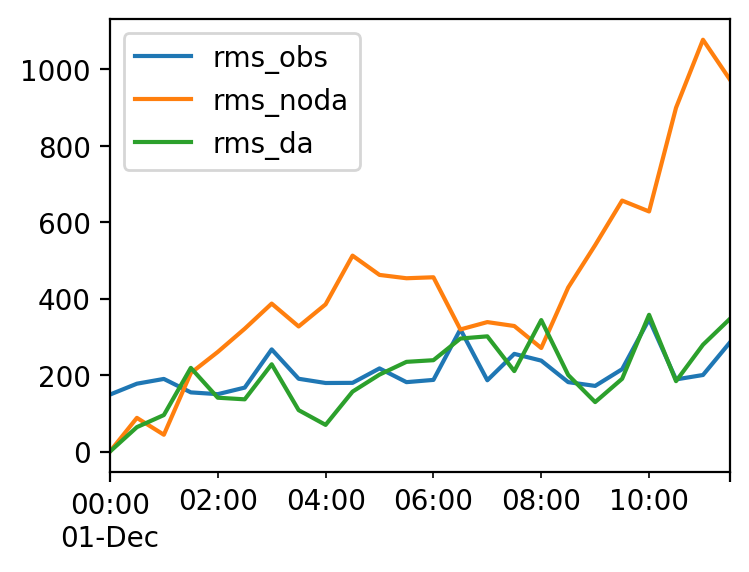

In [22]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=200)

pd.DataFrame(index=timestamps, data={'rms_obs': rms_observation,
                                     'rms_noda': rms_no_da,
                                     'rms_da': rms_da}).plot(ax=ax)